## Data Acquisition

In [1]:
companies = {'Tesla':{'stock name': 'TSLA'},
             'Ford':{'stock name': 'F'},
             'General Motors':{'stock name': 'GM'}}
company = 'Ford'
start = '2020-12-21'
end = '2021-12-21'


In [2]:
import requests
import sys

stock_name = companies[company]['stock name']
url = 'http://finance.yahoo.com/quote/'+stock_name+'/history?p='+stock_name
response = requests.get(url)

### Google News API

In [3]:
!pip install GoogleNews

In [4]:
from GoogleNews import GoogleNews
googlenews = GoogleNews()

In [5]:
print(googlenews.getVersion())

1.6.0


In [6]:
googlenews.set_lang('en')

In [7]:
#googlenews = GoogleNews(lang='en', region='US', start='02/01/2020', end='02/28/2020')#period='7d'

In [8]:
googlenews.search(company.lower())

In [9]:
googlenews.total_count()

130

In [10]:
googlenews.results()

[{'title': "How Akira Kurosawa and Francis Ford Coppola inspired 'Lost in Translation'",
  'media': 'Far Out Magazine',
  'date': '9 mins ago',
  'datetime': None,
  'desc': "Sofia Coppola's Lost in Translation drew inspiration from many great \nsources such as Francis Ford Coppola as well as the Japanese auteur Akira \nKurosawa.",
  'link': 'https://faroutmagazine.co.uk/how-akira-kurosawa-and-francis-ford-coppola-inspired-lost-in-translation/',
  'img': 'data:image/gif;base64,R0lGODlhAQABAIAAAP///////yH5BAEKAAEALAAAAAABAAEAAAICTAEAOw=='},
 {'title': 'Time for Doug Ford to step up for small businesses',
  'media': 'Green Party of Ontario',
  'date': '1 mins ago',
  'datetime': None,
  'desc': "GUELPH – Mike Schreiner made the following statement regarding small \nbusinesses: “The federal government's announcement of expanding supports \nfor workers...",
  'link': 'https://gpo.ca/2021/12/22/time-for-doug-ford-to-step-up-for-small-businesses/',
  'img': 'data:image/gif;base64,R0lGODlhAQA

In [11]:
googlenews.get_texts()

["How Akira Kurosawa and Francis Ford Coppola inspired 'Lost in Translation'",
 'Time for Doug Ford to step up for small businesses',
 'Chevrolet Silverado ZR2 price leak might make Ford happy',
 "Doug Ford's Ontario revealed to be alternate universe shown to suicidal man by Christmas angel",
 'Should You Accumulate Ford Motor Company (F) Stock Wednesday?',
 'Ford government announces new economic support measures for businesses impacted by COVID-19 restrictions',
 '2022 Ford F-150 Lightning, F-150 Hybrid offer Level-2 vehicle-to-vehicle charging',
 '‘Bachelorette’ Host Kaitlyn Bristowe Stuns in Purple Glittery Cocktail Dress and Gold Tom Ford Sandals for After-Show Finale',
 '2021 and 2022 Ford F-150 Recalled for Potentially Damaged Driveshaft',
 'Brandon Ford Offers Clearance Specials on the 2021 Ford Bronco Sport']

In [12]:
#googlenews.get_links()

In [13]:
googlenews.clear()

### New York Times API

In [14]:
import os
import json
import time
import requests
import datetime
import dateutil
import pandas as pd
from dateutil.relativedelta import relativedelta

In [15]:
YOUR_API_KEY = ''

In [16]:
q_start = start.replace('-','')
q_end = end.replace('-','')
q_term = company.lower().replace(' ','+')
def send_request(page):
    '''Sends a request to the NYT Search API to search article about company for given date.'''
    base_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?'
    url = base_url + 'q='+q_term+'&begin_date='+q_start+'&end_date='+q_end+'&page='+str(page)+'&sort=oldest&api-key='+YOUR_API_KEY
    response = requests.get(url).json()
    time.sleep(6)
    return response


def is_valid(article):
    '''An article is only worth checking if it has a headline.'''
    has_headline = type(article['headline']) == dict and 'main' in article['headline'].keys()
    return has_headline


def parse_response(data, response):
    '''Parses and returns response as pandas data frame.'''
    
    articles = response['response']['docs'] 
    for article in articles: 
        date = dateutil.parser.parse(article['pub_date']).date()
        if is_valid(article):
            data['date'].append(date)
            data['headline'].append(article['headline']['main']) 
            if 'section' in article:
                data['section'].append(article['section_name'])
            else:
                data['section'].append(None)
            data['doc_type'].append(article['document_type'])
            if 'type_of_material' in article: 
                data['material_type'].append(article['type_of_material'])
            else:
                data['material_type'].append(None)
            keywords = [keyword['value'] for keyword in article['keywords'] if keyword['name'] == 'subject']
            data['keywords'].append(keywords)
    return data


def get_data():
    '''Sends and parses request/response to/from NYT Search API for given dates.'''
    total = 0
    if not os.path.exists('TSLA_headlines'):
        os.mkdir('TSLA_headlines')
    page = 1
    data = {'headline': [],  
        'date': [], 
        'doc_type': [],
        'material_type': [],
        'section': [],
        'keywords': []}
    response = send_request(page)
    while(response['response']['docs']):
        data = parse_response(data, response)
        page += 1
        response = send_request(page)
    df = pd.DataFrame(data) 
    total = len(df)
    print('Number of articles collected: ' + str(total))
    return df

In [17]:
headlines_df = get_data()
headlines_df.head()

Number of articles collected: 931


,headline,date,doc_type,material_type,section,keywords
0,Mike Hoare Was a Soldier for Hire Who Led a Sp...,2020-12-23,multimedia,Interactive Feature,None,[Mercenaries and Private Military Contractors]
1,Konrad Steffen Was a Prophet of Climate Change...,2020-12-23,multimedia,Interactive Feature,None,"[Global Warming, Research]"
2,Mimi Jones Understood the Power of Public Resi...,2020-12-23,multimedia,Interactive Feature,None,"[Segregation and Desegregation, Civil Rights M..."
3,"Helen Reddy Embodied Her Feminist Anthem, ‘I A...",2020-12-23,multimedia,Interactive Feature,None,"[Women's Rights, Pop and Rock Music]"
4,Stanley Chera Was a Mogul Who Made Covid-19 Pe...,2020-12-23,multimedia,Interactive Feature,None,"[Real Estate and Housing (Residential), Real E..."


In [18]:
headlines_df.to_csv('./data/'+stock_name+'_headlines.csv', index=False)

## Data Processing

### Headline data

In [19]:
headlines_df = pd.read_csv('./data/'+stock_name+'_headlines.csv')
headlines_df.head()

,headline,date,doc_type,material_type,section,keywords
0,Mike Hoare Was a Soldier for Hire Who Led a Sp...,2020-12-23,multimedia,Interactive Feature,NaN,['Mercenaries and Private Military Contractors']
1,Konrad Steffen Was a Prophet of Climate Change...,2020-12-23,multimedia,Interactive Feature,NaN,"['Global Warming', 'Research']"
2,Mimi Jones Understood the Power of Public Resi...,2020-12-23,multimedia,Interactive Feature,NaN,"['Segregation and Desegregation', 'Civil Right..."
3,"Helen Reddy Embodied Her Feminist Anthem, ‘I A...",2020-12-23,multimedia,Interactive Feature,NaN,"[""Women's Rights"", 'Pop and Rock Music']"
4,Stanley Chera Was a Mogul Who Made Covid-19 Pe...,2020-12-23,multimedia,Interactive Feature,NaN,"['Real Estate and Housing (Residential)', 'Rea..."


In [20]:
#Pack all the relevant headlines in a day and add a headline count per day as a feature
headlines_df = headlines_df.groupby(['date']).agg({'headline': lambda x: ", ".join(x),
                                                   'doc_type':lambda x: x.tolist(),
                                                   'material_type':lambda x: x.tolist(),
                                                   'keywords':lambda x: x.tolist(),
                                                   'section':'size'}).rename({'section' : 'headlines_count'},axis=1).reset_index()
headlines_df.head()

,date,headline,doc_type,material_type,keywords,headlines_count
0,2020-12-23,Mike Hoare Was a Soldier for Hire Who Led a Sp...,"[multimedia, multimedia, multimedia, multimedi...","[Interactive Feature, Interactive Feature, Int...",[['Mercenaries and Private Military Contractor...,19
1,2020-12-24,"Rolling Homes That Make an R.V. Look Palatial,...","[article, article, multimedia, article]","[News, News, Interactive Feature, Obituary (Ob...","[['Automobiles', 'Road Trips', 'Travel and Vac...",4
2,2020-12-25,"Brexit Deal Done, Britain Now Scrambles to See...",[article],[News],"[['Great Britain Withdrawal from EU (Brexit)',...",1
3,2020-12-26,"Dad Got the Vaccine, but No One Else Did — Yet",[article],[News],"[['Coronavirus (2019-nCoV)', 'Vaccination and ...",1
4,2020-12-27,"The Haunting of Tulsa, Okla.",[article],[Op-Ed],"[['Tulsa Race Riot (1921)', 'Black People', 'B...",1


In [21]:
#Count the number of times the name of the company appeared in the headlines

def num_mentioned(headline):
    return (headline.lower().count(company.lower()))

headlines_df['company_included'] = headlines_df['headline'].apply(lambda x: num_mentioned(x))
headlines_df.head()

,date,headline,doc_type,material_type,keywords,headlines_count,company_included
0,2020-12-23,Mike Hoare Was a Soldier for Hire Who Led a Sp...,"[multimedia, multimedia, multimedia, multimedi...","[Interactive Feature, Interactive Feature, Int...",[['Mercenaries and Private Military Contractor...,19,0
1,2020-12-24,"Rolling Homes That Make an R.V. Look Palatial,...","[article, article, multimedia, article]","[News, News, Interactive Feature, Obituary (Ob...","[['Automobiles', 'Road Trips', 'Travel and Vac...",4,0
2,2020-12-25,"Brexit Deal Done, Britain Now Scrambles to See...",[article],[News],"[['Great Britain Withdrawal from EU (Brexit)',...",1,0
3,2020-12-26,"Dad Got the Vaccine, but No One Else Did — Yet",[article],[News],"[['Coronavirus (2019-nCoV)', 'Vaccination and ...",1,0
4,2020-12-27,"The Haunting of Tulsa, Okla.",[article],[Op-Ed],"[['Tulsa Race Riot (1921)', 'Black People', 'B...",1,0


In [22]:
headlines_df['date'] = headlines_df['date'].apply(lambda x: dateutil.parser.parse(x).date())
headlines_df = headlines_df.set_index(pd.DatetimeIndex(headlines_df['date']))
headlines_df = headlines_df.drop(['date'], axis=1)
headlines_df.head()

,headline,doc_type,material_type,keywords,headlines_count,company_included
date,,,,,,
2020-12-23,Mike Hoare Was a Soldier for Hire Who Led a Sp...,"[multimedia, multimedia, multimedia, multimedi...","[Interactive Feature, Interactive Feature, Int...",[['Mercenaries and Private Military Contractor...,19,0
2020-12-24,"Rolling Homes That Make an R.V. Look Palatial,...","[article, article, multimedia, article]","[News, News, Interactive Feature, Obituary (Ob...","[['Automobiles', 'Road Trips', 'Travel and Vac...",4,0
2020-12-25,"Brexit Deal Done, Britain Now Scrambles to See...",[article],[News],"[['Great Britain Withdrawal from EU (Brexit)',...",1,0
2020-12-26,"Dad Got the Vaccine, but No One Else Did — Yet",[article],[News],"[['Coronavirus (2019-nCoV)', 'Vaccination and ...",1,0
2020-12-27,"The Haunting of Tulsa, Okla.",[article],[Op-Ed],"[['Tulsa Race Riot (1921)', 'Black People', 'B...",1,0


### Stocks Data

In [23]:
# Load historical stock prices
stocks_df = pd.read_csv('./data/'+stock_name+'.csv')
stocks_df['date'] = stocks_df['Date'].apply(lambda x: dateutil.parser.parse(x).date())
stocks_df = stocks_df.set_index(pd.DatetimeIndex(stocks_df['date']))
stocks_df = stocks_df.drop(['date','Date'], axis=1)
stocks_df.head()

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2020-12-22,8.98,8.99,8.75,8.79,8.745962,59031200
2020-12-23,8.82,9.03,8.80,8.99,8.944960,54086700
2020-12-24,9.01,9.02,8.80,8.86,8.815611,27927000
2020-12-28,8.92,8.98,8.86,8.89,8.845461,38068400
2020-12-29,8.93,8.93,8.78,8.82,8.775811,37537900


<AxesSubplot:xlabel='date'>

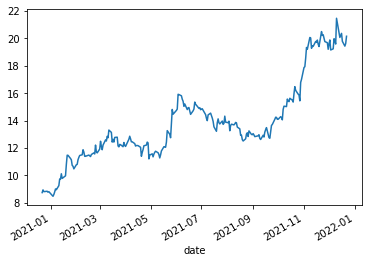

In [24]:
stocks_df['Adj Close'].plot()

We predict the stock price and if price is 10% higher or lower than the expected value, we trigger an alarm. In a simpler case, an alarm could be triggered if the current price differs more than 10% from the open price of the same day.

In [25]:
trigger_diff = 0.03
def if_triggers(row):
    if((row['Close'] < (1-trigger_diff)*row['Open'])|(row['Close'] > (1+trigger_diff)*row['Open'])):
        return 1
    else:
        return 0
stocks_df['Triggers']=stocks_df.apply(lambda row: if_triggers(row), axis=1)
stocks_df[stocks_df['Triggers'] == 1].head(50)

,Open,High,Low,Close,Adj Close,Volume,Triggers
date,,,,,,,
2021-01-04,8.810000,8.840000,8.430000,8.520000,8.477315,85043100,1
2021-01-11,8.870000,9.320000,8.820000,9.300000,9.253407,95968300,1
2021-01-12,9.300000,9.820000,9.290000,9.780000,9.731002,124808500,1
2021-01-14,9.810000,10.200000,9.790000,10.170000,10.119048,112695300,1
2021-01-20,10.230000,10.870000,10.190000,10.860000,10.805591,125033200,1
2021-02-09,11.540000,12.040000,11.490000,11.930000,11.870231,102250800,1
2021-02-24,11.670000,12.400000,11.640000,12.270000,12.208528,95152800,1
2021-02-25,12.220000,12.400000,11.720000,11.760000,11.701082,75249400,1
2021-03-02,12.040000,12.800000,11.940000,12.550000,12.487124,104789000,1


In [26]:
stocks_df = stocks_df.drop(['Open','High','Low','Close','Adj Close', 'Volume'], axis=1)
stocks_df.head()

,Triggers
date,
2020-12-22,0
2020-12-23,0
2020-12-24,0
2020-12-28,0
2020-12-29,0


### Combine the headline and stock data

In [27]:
import pandas as pd
df = pd.concat([headlines_df, stocks_df], axis=1)
df.head()

,headline,doc_type,material_type,keywords,headlines_count,company_included,Triggers
date,,,,,,,
2020-12-22,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-12-23,Mike Hoare Was a Soldier for Hire Who Led a Sp...,"[multimedia, multimedia, multimedia, multimedi...","[Interactive Feature, Interactive Feature, Int...",[['Mercenaries and Private Military Contractor...,19.0,0.0,0.0
2020-12-24,"Rolling Homes That Make an R.V. Look Palatial,...","[article, article, multimedia, article]","[News, News, Interactive Feature, Obituary (Ob...","[['Automobiles', 'Road Trips', 'Travel and Vac...",4.0,0.0,0.0
2020-12-25,"Brexit Deal Done, Britain Now Scrambles to See...",[article],[News],"[['Great Britain Withdrawal from EU (Brexit)',...",1.0,0.0,NaN
2020-12-26,"Dad Got the Vaccine, but No One Else Did — Yet",[article],[News],"[['Coronavirus (2019-nCoV)', 'Vaccination and ...",1.0,0.0,NaN


We notice that some days news articles are missing. So, we remove any date with Nan values.

In [28]:
df.dropna(inplace=True)
df.head()

,headline,doc_type,material_type,keywords,headlines_count,company_included,Triggers
date,,,,,,,
2020-12-23,Mike Hoare Was a Soldier for Hire Who Led a Sp...,"[multimedia, multimedia, multimedia, multimedi...","[Interactive Feature, Interactive Feature, Int...",[['Mercenaries and Private Military Contractor...,19.0,0.0,0.0
2020-12-24,"Rolling Homes That Make an R.V. Look Palatial,...","[article, article, multimedia, article]","[News, News, Interactive Feature, Obituary (Ob...","[['Automobiles', 'Road Trips', 'Travel and Vac...",4.0,0.0,0.0
2020-12-28,What’s on TV This Week: ‘Jimmy Carter Rock & R...,"[article, article, article, article, article]","[News, News, News, News, News]","[['Television', 'Movies'], ['Baseball'], ['Ele...",5.0,0.0,0.0
2020-12-29,Employers are struggling to manage unused vaca...,"[article, article, article]","[News, News, Letter]","[['internal-essential'], ['Haitian-Americans',...",3.0,0.0,0.0
2020-12-30,"The Great News Quiz of 2020, A Year Filled Wit...","[multimedia, article, article]","[Interactive Feature, Obituary (Obit), News]","[['Two Thousand Twenty'], ['Deaths (Obituaries...",3.0,0.0,0.0


In [29]:
#Set Target Variable
output_df = pd.DataFrame(df['Triggers'])
output_df.head()

,Triggers
date,
2020-12-23,0.0
2020-12-24,0.0
2020-12-28,0.0
2020-12-29,0.0
2020-12-30,0.0


In [30]:
df = df.drop(['doc_type','material_type','keywords'], axis=1)
df = df.reset_index()
df.head()

,date,headline,headlines_count,company_included,Triggers
0,2020-12-23,Mike Hoare Was a Soldier for Hire Who Led a Sp...,19.0,0.0,0.0
1,2020-12-24,"Rolling Homes That Make an R.V. Look Palatial,...",4.0,0.0,0.0
2,2020-12-28,What’s on TV This Week: ‘Jimmy Carter Rock & R...,5.0,0.0,0.0
3,2020-12-29,Employers are struggling to manage unused vaca...,3.0,0.0,0.0
4,2020-12-30,"The Great News Quiz of 2020, A Year Filled Wit...",3.0,0.0,0.0


### NLP Features

Now, we add NLP features of the headlines.

In [31]:
import nltk
import string
import re

def clean_text(text):
    """
    Clean the text by removing punctuations and stopwords and applying tokenization and stemming
    :param text: a string
    :return: a cleaned string
    """
    stopword = nltk.corpus.stopwords.words('english')
    ps = nltk.PorterStemmer()

    headline = "".join([word.lower() for word in text if word not in string.punctuation])  # Remove punctuation
    tokens = re.split('\W+', headline)  # Tokenization
    headline = " ".join([ps.stem(word) for word in tokens if word not in stopword])  # Remove stopwords and Stemming

    return headline

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(df['headline'])
print(X_tfidf.shape)

(237, 39)


In [33]:
#Save the vocabulary
import pickle

pickle.dump(tfidf_vect.vocabulary_, open('./model/'+stock_name+'feature.pkl', 'wb'))

In [34]:
X_features = pd.concat([df['date'], df['headlines_count'], df['company_included'], pd.DataFrame(X_tfidf.toarray())], axis=1)
X_features = X_features.set_index(pd.DatetimeIndex(X_features['date']))
X_features = X_features.drop(['date'], axis=1)
X_features.head()

,headlines_count,company_included,0,1,2,3,4,5,6,7,...,29,30,31,32,33,34,35,36,37,38
date,,,,,,,,,,,,,,,,,,,,,
2020-12-23,19.0,0.0,0.581676,0.000000,0.0124,0.013532,0.01485,0.0,0.000000,0.0,...,0.146071,0.223092,0.109626,0.056138,0.048822,0.022334,0.054796,0.012502,0.0,0.0
2020-12-24,4.0,0.0,0.501430,0.250913,0.0000,0.286953,0.00000,0.0,0.073858,0.0,...,0.106814,0.231405,0.029059,0.132275,0.000000,0.059204,0.000000,0.132559,0.0,0.0
2020-12-28,5.0,0.0,0.590870,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.0,...,0.186470,0.179543,0.126825,0.057729,0.056482,0.000000,0.126787,0.000000,0.0,0.0
2020-12-29,3.0,0.0,0.501464,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.0,...,0.267054,0.183667,0.207582,0.047244,0.000000,0.000000,0.103759,0.000000,0.0,0.0
2020-12-30,3.0,0.0,0.598237,0.176091,0.0000,0.201384,0.00000,0.0,0.000000,0.0,...,0.074962,0.108267,0.081576,0.139246,0.090825,0.000000,0.101939,0.093030,0.0,0.0


In [50]:
### Train and test sets

In [51]:
#Splitting to Training set and Test set
from sklearn.model_selection import TimeSeriesSplit

timesplit= TimeSeriesSplit(n_splits=30)
for train_index, test_index in timesplit.split(X_features):
        X_train, X_test = X_features[:len(train_index)], X_features[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_df[:len(train_index)].values.ravel(), output_df[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [52]:
print(X_train.shape)

(230, 41)


In [53]:
y_test

array([1., 0., 0., 0., 0., 0., 0.])

## Model Training

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
from sklearn.model_selection import KFold, cross_val_score

In [56]:
rf = RandomForestClassifier(max_depth = 90, n_jobs=-1, class_weight='balanced')
k_fold = KFold(n_splits=5)

# evaluate model
cross_val_score(rf, X_train, y_train, cv=k_fold, scoring='f1_micro', n_jobs=-1)

array([0.7826087 , 0.86956522, 0.80434783, 0.95652174, 0.82608696])

## Model Evaluation

In [57]:
X_test.head()

,headlines_count,company_included,0,1,2,3,4,5,6,7,...,29,30,31,32,33,34,35,36,37,38
date,,,,,,,,,,,,,,,,,,,,,
2021-12-13,3.0,0.0,0.558772,0.000000,0.0,0.000000,0.000000,0.10375,0.0,0.0,...,0.156618,0.211120,0.170435,0.077580,0.037952,0.000000,0.085192,0.000000,0.0,0.0
2021-12-14,2.0,0.0,0.549091,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.097473,0.234630,0.159108,0.120707,0.000000,0.108052,0.066275,0.000000,0.0,0.0
2021-12-15,5.0,0.0,0.628264,0.000000,0.0,0.000000,0.078912,0.00000,0.0,0.0,...,0.294432,0.231950,0.145640,0.033147,0.097292,0.118686,0.036399,0.000000,0.0,0.0
2021-12-16,5.0,0.0,0.547641,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.136101,0.112325,0.063475,0.120388,0.094230,0.000000,0.000000,0.000000,0.0,0.0
2021-12-17,4.0,0.0,0.556577,0.051576,0.0,0.058984,0.064729,0.00000,0.0,0.0,...,0.241515,0.126842,0.047786,0.081568,0.053204,0.000000,0.000000,0.054496,0.0,0.0


In [58]:
"""import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

transform_test = X_test['headline'].apply(lambda x: clean_text(x))

cleaned_text = clean_text('The S.E.C. Wants to Cut SPACs Down to Size')
transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="replace", vocabulary=pickle.load(open("./model/feature.pkl", "rb")))
X_test_tfidf = transformer.fit_transform(loaded_vec.fit_transform(np.array([cleaned_text])))
test_features = X_test_tfidf.toarray()
print(test_features.shape)
test_features
"""

'import numpy as np\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.feature_extraction.text import TfidfTransformer\n\ntransform_test = X_test[\'headline\'].apply(lambda x: clean_text(x))\n\ncleaned_text = clean_text(\'The S.E.C. Wants to Cut SPACs Down to Size\')\ntransformer = TfidfTransformer()\nloaded_vec = CountVectorizer(decode_error="replace", vocabulary=pickle.load(open("./model/feature.pkl", "rb")))\nX_test_tfidf = transformer.fit_transform(loaded_vec.fit_transform(np.array([cleaned_text])))\ntest_features = X_test_tfidf.toarray()\nprint(test_features.shape)\ntest_features\n'

In [59]:
n_est = 100
max_depth = 60

rf = RandomForestClassifier(n_estimators=n_est, max_depth=max_depth, n_jobs=-1, class_weight = 'balanced')
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [60]:
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)

[(0.05738576851600053, 22),
 (0.05737798981679483, 24),
 (0.05130553822393483, 0),
 (0.045054034920634346, 25),
 (0.04448422437999857, 19),
 (0.04261598253149852, 12),
 (0.04027762778895076, 15),
 (0.03907205940761777, 30),
 (0.03764091617765536, 26),
 (0.0366364081147386, 28),
 (0.03519614091594884, 18),
 (0.035105645984185134, 29),
 (0.03480612792863436, 23),
 (0.0338656300752325, 33),
 (0.03355770875968267, 11),
 (0.03311030982782753, 14),
 (0.03247421670645273, 16),
 (0.032279296217139, 21),
 (0.03075142273834029, 13),
 (0.02759786373189756, 31),
 (0.026212653748625976, 35),
 (0.02595676774429998, 32),
 (0.02589373416868677, 17),
 (0.0184952481925672, 'headlines_count'),
 (0.01740001450767749, 34),
 (0.015047428016278645, 2),
 (0.010970574213784851, 3),
 (0.010737818772071332, 6),
 (0.010504003346947595, 1),
 (0.009264031125518752, 36),
 (0.009088844584587969, 20),
 (0.008331937181314027, 27),
 (0.006964679937053366, 9),
 (0.005487447053503315, 10),
 (0.00454478428883636, 8),
 (0.0

In [61]:
import joblib

joblib.dump(rf_model, './model/'+stock_name+'_RF_model.pkl')

['./model/F_RF_model.pkl']

In [62]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, train_support = score(y_test, y_pred, average=None)

/Users/MT/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print(precision)

[0.85714286 0.        ]


In [64]:
print(recall)

[1. 0.]


In [65]:
print(fscore)

[0.92307692 0.        ]


## Explore Parameters with GridSearch

In [43]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [44]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 50, 100],
        'max_depth': [60, 90, None],
        'class_weight': ['balanced']}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_train, y_train)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.105578,0.023414,0.011893,0.003191,balanced,60,50,"{'class_weight': 'balanced', 'max_depth': 60, ...",0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,1.110223e-16,1
2,0.208313,0.046444,0.017619,0.004197,balanced,60,100,"{'class_weight': 'balanced', 'max_depth': 60, ...",0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,1.110223e-16,1
3,0.027454,0.000732,0.005579,0.000212,balanced,90,10,"{'class_weight': 'balanced', 'max_depth': 90, ...",0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,1.110223e-16,1
4,0.120232,0.004244,0.012046,0.000778,balanced,90,50,"{'class_weight': 'balanced', 'max_depth': 90, ...",0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,1.110223e-16,1
5,0.245963,0.006813,0.022906,0.002446,balanced,90,100,"{'class_weight': 'balanced', 'max_depth': 90, ...",0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,1.110223e-16,1
